# SACC file creation for binned cluster analysis

This demo notebook examplifies storing information for a binned cluster analysis into a sacc format. Steps are the following:
- generate a mock cluster catalog in richness-redshift bins. This is done using NumCosmo functionalities and requires Numcosmo v>=0.17
- in each bin, generate a mock radial shear profile using CLMM. This is meant to correspond to the stacked shear profile in that bin.
- store all this information using the SACC framework.
- show how to recover the information from the SACC file.

In [1]:
import os
import math
import itertools
import numpy as np
from astropy.table import Table
from astropy.io import fits
from scipy import stats
import matplotlib.pyplot as plt

# This require Numcosmo v>=0.17
from numcosmo_py import Nc
from numcosmo_py import Ncm

from firecrown.sacc_support import sacc

os.environ['CLMM_MODELING_BACKEND'] = 'nc' # Need to use NumCosmo as CLMM's backend as well.
import clmm
from clmm import Cosmology

## Prepare NumCosmo cosmology

In [2]:
H0 = 71.0
Ob0 = 0.0448
Odm0 = 0.22
n_s = 0.963
sigma8 = 0.8

Ncm.cfg_init()
#cosmo = Nc.HICosmoDEXcdm() # not (yet) supported by CLMM --> using Nc.HICosmoDECpl() instead
cosmo = Nc.HICosmoDECpl()
reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)

# psml = Nc.PowspecMLCBE.new ()
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()

cosmo.props.H0 = H0
cosmo.props.Omegab = Ob0
cosmo.props.Omegac = Odm0

cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.0)

prim.props.n_SA = n_s

old_amplitude = math.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log((sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude)

## Generate a mock cluster catalog using NumCosmo

NumCosmo has a built-in functionality to generate mock cluster catalogs, from a given halo mass function (HMF) and with a log-normal richness-mass relation. 
- For the HMF, the code below uses the Tinker (2008) definition. 
- For the richness-mass relation, six parameters can be specified as the NumCosmo functionality allows for the mean relation and scatter of the log-normal distribution to have a linear dependences with both log(mass) and log(1+z) (that's 2 parameters and a normalisation, for both the mean relation and the scatter). 

Below we use the Murata et al. (2019) parameters (from their Table 1), but neglecting the quadratic dependence in redshift they use (this is inconsistent, but sufficient to generate this mock dataset)

In [3]:
# Define the sky area and the richness and redshift ranges
area = 5000. # deg2
lnRl = 0.0
lnRu = 6.0
zl = 0.2
zu = 0.65

cluster_z = Nc.ClusterRedshift.new_from_name(
    f"NcClusterRedshiftNodist{{'z-min': <{zl:22.15e}>, 'z-max':<{zu:22.15e}>}}"
)

cluster_m = Nc.ClusterMass.new_from_name(
    f"NcClusterMassAscaso{{'M0':<{3.0e14 / 0.71:22.15e}>,'z0':<0.6>, "
    f"'lnRichness-min':<{lnRl:22.15e}>, 'lnRichness-max':<{lnRu:22.15e}>}}"
)

# mean richness-mass relation parameters
cluster_m.param_set_by_name("mup0", 3.15) # normalisation
cluster_m.param_set_by_name("mup1", 0.86 / np.log(10)) # mass dependence, adapted to match the log10 definition used in NumCosmo
cluster_m.param_set_by_name("mup2", -0.21 / np.log(10)) # redshift dependence, adapted to match the log10 definition used in NumCosmo
# richness-mass scatter parameter
cluster_m.param_set_by_name("sigmap0", 0.33) # normalisation
cluster_m.param_set_by_name("sigmap1", -0.08 / np.log(10)) # mass dependence, adapted to match the log10 definition used in NumCosmo
cluster_m.param_set_by_name("sigmap2", 0.03 / np.log(10)) # redshift dependence, adapted to match the log10 definition used in NumCosmo

 
# Numcosmo Mass Function
# First, define the multiplicity function. 
mulf = Nc.MultiplicityFuncTinker.new() # Tinker (2008)
mulf.set_linear_interp(True)  # This reproduces the linear interpolation done in CCL
mulf.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
mulf.set_Delta(200)

# Second, construct a filtered power spectrum
hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area_sd(area)

# Cluster Abundance Obj
ca = Nc.ClusterAbundance.new(hmf, None)

# Number Counts object
ncount = Nc.DataClusterNCount.new(
    ca, "NcClusterRedshiftNodist", "NcClusterMassAscaso"
)
ca.prepare(cosmo, cluster_z, cluster_m)
mset = Ncm.MSet.new_array([cosmo, cluster_z, cluster_m])

rng = Ncm.RNG.seeded_new(None, 32)
ncount.init_from_sampling(mset, area * ((np.pi / 180) ** 2), rng)

ncount.catalog_save("ncount_rich.fits", True)
ncdata_fits = fits.open("ncount_rich.fits")
ncdata_data = ncdata_fits[1].data 
ncdata_Table = Table(ncdata_data)

## Next, in the $N_{\rm richness} \times N_z$ richness-redshift plane:
- count halos and compute mean mass in each bin, directly from the data generated at the previous step
- associate a "mock" shear profile, generated using CLMM from the mean mass in the bin, mock diagonal inter-radial bin covariance. Very rough/quick solution to get some "shear profile data".


### Counts and mean mass

**To check**: below this was originally computing the mean(log M) and mean(M). I've switched to the latter.

In [4]:
data_table = ncdata_Table[ncdata_Table["LNM_OBS"] > 2]
cluster_z = data_table["Z_OBS"]
cluster_lnm = data_table["LNM_OBS"]
cluster_richness = cluster_lnm / np.log(10.0)
#cluster_logM = data_table["LNM_TRUE"] / np.log(10.0)
cluster_M = np.exp(data_table["LNM_TRUE"])

N_richness = 4  # number of richness bins
N_z = 3  # number of redshift bins

cluster_counts, z_edges, richness_edges, _ = stats.binned_statistic_2d(
    cluster_z, cluster_richness, cluster_M, "count", bins=[N_z, N_richness]
)

# # statistics on log10(M)
# mean_logM = stats.binned_statistic_2d(
#     cluster_z,
#     cluster_richness,
#     cluster_logM,
#     "mean",
#     bins=[z_edges, richness_edges],
# ).statistic

# std_logM = stats.binned_statistic_2d(
#     cluster_z, cluster_richness, cluster_logM, "std", bins=[z_edges, richness_edges]
# ).statistic
# var_mean_logM = std_logM**2 / cluster_counts 


# to me it makes more sense the take the mean of the masses, and then take the log10 of this if we rather display things in log.
mean_M = stats.binned_statistic_2d(
    cluster_z,
    cluster_richness,
    cluster_M,
    "mean",
    bins=[z_edges, richness_edges],
).statistic

std_M = stats.binned_statistic_2d(
    cluster_z, cluster_richness, cluster_M, "std", bins=[z_edges, richness_edges]
).statistic

var_mean_M = std_M**2 / cluster_counts 

# ** Correlation matrix - the "large blocks" correspond to the $N_z$ redshift bins.
# In each redshift bin are the $N_{\rm richness}$ richness bins.**

# covariance = np.diag(
#     np.concatenate((cluster_counts.flatten(), var_mean_logM.flatten()))
# )

# Make mock diagonal covariance considering Poisson noise for the counts, and dispersion for the mean mass.
covariance = np.diag(
    np.concatenate((cluster_counts.flatten(), var_mean_M.flatten()))
)

### Saving to SACC

In [5]:
s_count = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []

survey_name = "NC_mock_redshift_richness"
s_count.add_tracer("cluster_survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_lower, z_upper = z_bin
    bin_z_label = f"bin_z_{i}"
    s_count.add_tracer("bin_z", bin_z_label, z_lower, z_upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(richness_edges[:-1], richness_edges[1:])):
    richness_lower, richness_upper = richness_bin
    bin_richness_label = f"bin_rich_{i}"
    s_count.add_tracer(
        "bin_richness", bin_richness_label, richness_lower, richness_upper
    )
    bin_richness_labels.append(bin_richness_label)

cluster_count = sacc.standard_types.cluster_counts
cluster_mean_mass = sacc.standard_types.cluster_mean_mass

counts_and_edges = zip(
    cluster_counts.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)

# mean_logM_and_edges = zip(
#     mean_logM.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
# )

mean_M_and_edges = zip(
    mean_M.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)


for counts, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count.add_data_point(
        cluster_count, (survey_name, bin_z_label, bin_richness_label), int(counts)
    )

# for bin_mean_logM, (bin_z_label, bin_richness_label) in mean_logM_and_edges:
#     s_count.add_data_point(
#         cluster_mean_mass,
#         (survey_name, bin_z_label, bin_richness_label),
#         bin_mean_logM,
#     )

    
for bin_mean_M, (bin_z_label, bin_richness_label) in mean_M_and_edges:
    s_count.add_data_point(
        cluster_mean_mass,
        (survey_name, bin_z_label, bin_richness_label),
        bin_mean_M,
    )

# ### Then the add the covariance and save the file

s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("cluster_redshift_richness_sacc_data.fits", overwrite=True)

### Loading SACC file and check contents

In [6]:
s2 = sacc.Sacc.load_fits("./cluster_redshift_richness_sacc_data.fits")

In [7]:
s2.get_data_types()

['cluster_counts', 'cluster_mean_mass']

In [8]:
s2.data

[DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_0', 'bin_rich_0'), value=74639, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_0', 'bin_rich_1'), value=26398, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_0', 'bin_rich_2'), value=3158, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_0', 'bin_rich_3'), value=105, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_1', 'bin_rich_0'), value=135594, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_1', 'bin_rich_1'), value=45119, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_1', 'bin_rich_2'), value=4894, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_1', 'bin_rich_3'), value=162, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_m

#### Look at covariance. 
Plotting log10 of the covariance for display purposes. The first upper left block correspond to the count covariance. 
The lower right block to the mean mass covariance. No off-diagonal terms were considered in this simple example. This is just a place holder to show how the SACC file is filled in.

/var/folders/93/85_nzcl92sl4qnnfgmrrwkd40000gn/T/ipykernel_54060/1676763377.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(s2.covariance.covmat))


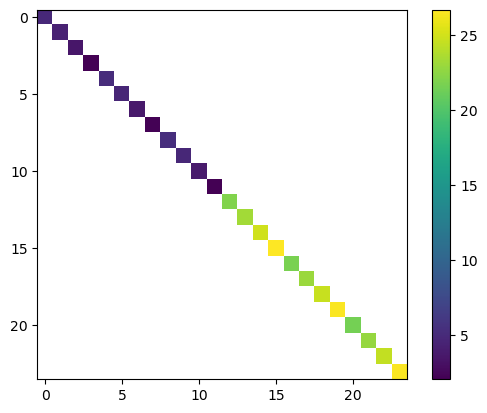

In [9]:
plt.imshow(np.log10(s2.covariance.covmat))
plt.colorbar()

## Saving a shear profile instead of the mean mass

Rather than saving the mean mass into SACC, one may want to save the 'stacked' shear profile in a richness-redshift bin. This possible as exemplified below. 

### Prepare new sacc, filling in with counts (same as above)

In [8]:
s_count2 = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []

survey_name = "NC_mock_redshift_richness"
s_count2.add_tracer("cluster_survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_lower, z_upper = z_bin
    bin_z_label = f"bin_z_{i}"
    s_count2.add_tracer("bin_z", bin_z_label, z_lower, z_upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(richness_edges[:-1], richness_edges[1:])):
    richness_lower, richness_upper = richness_bin
    bin_richness_label = f"bin_rich_{i}"
    s_count2.add_tracer(
        "bin_richness", bin_richness_label, richness_lower, richness_upper
    )
    bin_richness_labels.append(bin_richness_label)

cluster_count = sacc.standard_types.cluster_counts
counts_and_edges = zip(
    cluster_counts.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)
for counts, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count2.add_data_point(
        cluster_count, (survey_name, bin_z_label, bin_richness_label), int(counts)
    )


#### Use CLMM to generate a mock shear profile

In [23]:
# Setting things up for CLMM
cosmo_clmm = Cosmology()
cosmo_clmm._init_from_cosmo(cosmo)
moo = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="nfw")
moo.set_cosmo(cosmo_clmm)
# assuming the same concentration for all masses. Not realistic, but avoid having to call a mass-concentration relation. Does
moo.set_concentration(4)

# we'll need the mean redshift of the clusters in the redshift bin
mean_z = stats.binned_statistic_2d(
    cluster_z,
    cluster_richness,
    cluster_z,
    "mean",
    bins=[z_edges, richness_edges],
).statistic

radius_edges = clmm.make_bins(0.3, 6., nbins=6, method="evenlog10width") # 6 radial bins log-spaced between 0.3 and 6 Mpc
radius_centers = [np.mean(radius_edges[i:i+1]) for i in np.arange(len(radius_edges)-1)]

In [24]:
bin_radius_labels = []
for i, radius_bin in enumerate(zip(radius_edges[:-1], radius_edges[1:])):
    radius_lower, radius_upper = richness_bin
    bin_radius_label = f"bin_radius_{i}"
    s_count2.add_tracer(
        "bin_radius", bin_radius_label, radius_lower, radius_upper
    )
    bin_radius_labels.append(bin_radius_label)
    
cluster_shear = sacc.standard_types.cluster_shear_profile

In [25]:
redshifts_masses_and_edges = zip(
    mean_z.flatten(), mean_M.flatten(),itertools.product(bin_z_labels, bin_richness_labels)
)
for redshift, mass, (bin_z_label, bin_richness_label) in redshifts_masses_and_edges:
    moo.set_mass(mass)
    profile = moo.eval_excess_surface_density(radius_centers, redshift)
    print(profile)
    for i,bin_radius_label in enumerate(bin_radius_labels):
        s_count2.add_data_point(
            cluster_shear, (survey_name, bin_z_label, bin_richness_label, bin_radius_label), profile[i]
    )
        

[3.37180316e+13 2.19501834e+13 1.29477322e+13 7.01206626e+12
 3.54180044e+12 1.69338263e+12]
[5.23007249e+13 3.59410173e+13 2.22860506e+13 1.25931410e+13
 6.58246364e+12 3.23270022e+12]
[8.50177534e+13 6.23076429e+13 4.11454000e+13 2.45865664e+13
 1.34608061e+13 6.85845983e+12]
[1.22075267e+14 9.40120597e+13 6.53747513e+13 4.09966157e+13
 2.33940909e+13 1.23265190e+13]
[3.77155523e+13 2.39703404e+13 1.38400870e+13 7.36330717e+12
 3.66702397e+12 1.73408638e+12]
[5.74730512e+13 3.83877162e+13 2.31794486e+13 1.28030766e+13
 6.56984554e+12 3.18012407e+12]
[9.46375529e+13 6.73909920e+13 4.32446074e+13 2.51824224e+13
 1.34925433e+13 6.75715929e+12]
[1.33499646e+14 9.97396607e+13 6.71743343e+13 4.08742381e+13
 2.27249024e+13 1.17229077e+13]
[4.14700958e+13 2.57836486e+13 1.46034868e+13 7.64778799e+12
 3.76151020e+12 1.76164508e+12]
[6.22250070e+13 4.05049408e+13 2.38909788e+13 1.29378311e+13
 6.53461166e+12 3.12417530e+12]
[9.96708941e+13 6.87685431e+13 4.28036630e+13 2.42667349e+13
 1.271838

In [26]:
s_count2.data

[DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_0', 'bin_rich_0'), value=74639, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_0', 'bin_rich_1'), value=26398, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_0', 'bin_rich_2'), value=3158, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_0', 'bin_rich_3'), value=105, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_1', 'bin_rich_0'), value=135594, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_1', 'bin_rich_1'), value=45119, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_1', 'bin_rich_2'), value=4894, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_richness', 'bin_z_1', 'bin_rich_3'), value=162, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_m

In [27]:
3*4*6


72